In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib
import seaborn as sns

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0005.hk',"2017-09-28","2021-09-24")
data.columns

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [3]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
# data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
data["% Change"]=data["Close"].pct_change()
data['3day MA'] = data['Close'].shift(1).rolling(window = 7).mean()
data['10day MA'] = data['Close'].shift(1).rolling(window = 14).mean()
data['30day MA'] = data['Close'].shift(1).rolling(window = 21).mean()
data['Std_dev']= data['Close'].rolling(5).std()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,3day MA,10day MA,30day MA,Std_dev
Date,,,,,,,,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,64.386993,22520013,1.049995,-0.200005,NaN,NaN,NaN,NaN,NaN
2017-09-29,76.500000,76.900002,76.300003,76.550003,64.682732,16766252,0.599998,0.050003,0.004593,NaN,NaN,NaN,NaN
2017-10-03,76.800003,77.449997,76.699997,77.449997,65.443199,24369212,0.750000,0.649994,0.011757,NaN,NaN,NaN,NaN
2017-10-04,77.500000,77.949997,77.500000,77.849998,65.781189,21197563,0.449997,0.349998,0.005165,NaN,NaN,NaN,NaN
2017-10-06,77.599998,77.800003,77.199997,77.349998,65.358719,23715110,0.600006,-0.250000,-0.006423,NaN,NaN,NaN,0.681542
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16,40.599998,40.599998,39.599998,40.000000,40.000000,19553563,1.000000,-0.599998,-0.002494,40.535715,41.060715,41.473810,0.396233
2021-09-17,39.700001,40.400002,39.099998,40.250000,40.250000,28266370,1.300003,0.549999,0.006250,40.392858,40.917858,41.311905,0.269259
2021-09-20,39.900002,39.950001,38.950001,39.000000,39.000000,23796781,1.000000,-0.900002,-0.031056,40.364286,40.817857,41.211905,0.517687


In [4]:
data_options = pd.read_csv("Put_Call_Ratio.csv",skiprows=1)
data_options.columns

Index(['Date (D/M/Y)', ' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [5]:
data_options['Date (D/M/Y)']=pd.to_datetime(data_options['Date (D/M/Y)'], format="%d/%m/%Y")
data_options.set_index('Date (D/M/Y)',inplace=True)
data_options.sort_index(ascending=True,inplace=True)
data_options.columns

Index([' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [6]:
data=pd.merge(data,data_options[" Put/Call Ratio"], left_index=True,right_index=True)
# data=data.drop(["Volume"], axis=1,inplace=False)
# data.drop(["Volume","Adj Close"], axis=1,inplace=True)

In [7]:
data.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
H-L                0
O-C                0
% Change           0
3day MA            0
10day MA           0
30day MA           0
Std_dev            0
 Put/Call Ratio    0
dtype: int64

In [8]:
data.dropna(inplace=True)
data.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
H-L                0
O-C                0
% Change           0
3day MA            0
10day MA           0
30day MA           0
Std_dev            0
 Put/Call Ratio    0
dtype: int64

In [9]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,3day MA,10day MA,30day MA,Std_dev,Put/Call Ratio
2020-09-28,28.350000,31.299999,28.250000,30.799999,29.670927,150402170,3.049999,2.449999,0.092199,29.342857,30.839286,31.695238,1.023718,0.8373
2020-09-29,30.850000,31.400000,30.000000,30.000000,28.900255,55920302,1.400000,-0.850000,-0.025974,29.328572,30.682143,31.542857,1.088347,1.3801
2020-09-30,30.500000,30.500000,29.650000,29.799999,28.707586,35285507,0.850000,-0.700001,-0.006667,29.192857,30.489286,31.361905,1.063954,1.4973
2020-10-05,30.700001,31.900000,30.700001,31.000000,29.863596,69650604,1.199999,0.299999,0.040268,29.264286,30.303571,31.185714,1.108151,0.8662
2020-10-06,31.100000,31.200001,30.750000,31.049999,29.911764,28877682,0.450001,-0.050001,0.001613,29.592857,30.214286,31.083333,0.586941,1.0145


In [10]:
data_price=data["Close"]
train=data.drop(["Volume"],1).values
sc = MinMaxScaler(feature_range=(0,1))
train=sc.fit_transform(train)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb)])
        print(data[i:(i+lb)])
        Y.append(data_price[(i+lb)])
    return np.array(X),np.array(Y)

lb=5
X,y = processData(train,data_price,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X.shape)
print(X[0])
print(data.shape)
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

[[0.         0.0486618  0.         0.04761905 0.04490179 1.
  1.         1.         0.00739959 0.0403453  0.07525234 0.42418692
  0.10502387]
 [0.11547344 0.053528   0.08293839 0.00952385 0.00898039 0.45901638
  0.16455691 0.10675503 0.00669486 0.03208859 0.06707552 0.45516483
  0.21770812]
 [0.09930714 0.0097324  0.0663507  0.         0.         0.27868872
  0.20253151 0.25269553 0.         0.02195535 0.05736554 0.44347296
  0.24203861]
 [0.10854505 0.0778589  0.11611379 0.05714289 0.05388218 0.39344235
  0.45569614 0.60747011 0.00352361 0.01219742 0.04791109 0.46465747
  0.11102346]
 [0.12702079 0.0437957  0.11848342 0.05952381 0.05612732 0.14754127
  0.36708842 0.31527932 0.0197322  0.00750611 0.04241728 0.21483056
  0.14181026]]
[[0.11547344 0.053528   0.08293839 0.00952385 0.00898039 0.45901638
  0.16455691 0.10675503 0.00669486 0.03208859 0.06707552 0.45516483
  0.21770812]
 [0.09930714 0.0097324  0.0663507  0.         0.         0.27868872
  0.20253151 0.25269553 0.         0.02

In [11]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(214, 5, 13) (214,) (24, 5, 13) (24,)


In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
# lstm_model.add(Dropout(0.4))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))
model.compile(
  loss='mean_squared_error',
  optimizer='Adam'
)

In [13]:
#Fit model with history to check for overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = model.fit(X_train,y_train,epochs=300,batch_size=20,validation_data=(X_test,y_test),shuffle=False)
 
model.summary() 

Epoch 1/300
11/11 [==============================] - 10s 52ms/step - loss: 1631.7880 - val_loss: 1628.6143
Epoch 2/300
11/11 [==============================] - 0s 6ms/step - loss: 1552.0647 - val_loss: 1455.5284
Epoch 3/300
11/11 [==============================] - 0s 5ms/step - loss: 1363.0901 - val_loss: 1153.7050
Epoch 4/300
11/11 [==============================] - 0s 5ms/step - loss: 1089.5956 - val_loss: 905.6109
Epoch 5/300
11/11 [==============================] - 0s 5ms/step - loss: 847.4594 - val_loss: 724.4739
Epoch 6/300
11/11 [==============================] - 0s 5ms/step - loss: 670.5568 - val_loss: 575.3657
Epoch 7/300
11/11 [==============================] - 0s 5ms/step - loss: 528.1965 - val_loss: 444.1992
Epoch 8/300
11/11 [==============================] - 0s 5ms/step - loss: 405.3177 - val_loss: 329.6929
Epoch 9/300
11/11 [==============================] - 0s 5ms/step - loss: 299.9797 - val_loss: 233.0005
Epoch 10/300
11/11 [==============================] - 0s 5ms/ste

In [14]:
# history = model.fit(
#     X_train, y_train,
#     epochs=100,
#     batch_size=16,
#     validation_split=0.1,
#     verbose=1,
#     shuffle=False
# )

In [15]:
y_pred = model.predict(X_test)

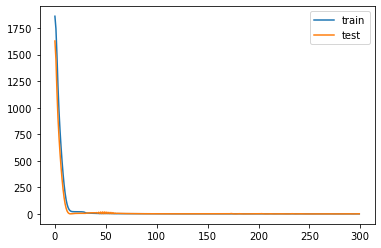

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

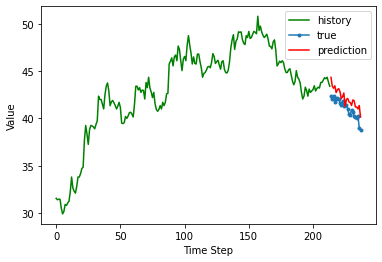

In [17]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [18]:
# plot_x=data[int(X.shape[0]*0.90):]
# plot_x["Prediction"]=y_test

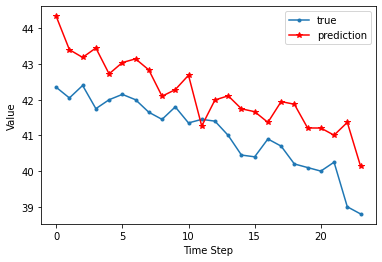

In [19]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [20]:
y_test

array([42.34999847, 42.04999924, 42.40000153, 41.75      , 42.        ,
       42.15000153, 42.        , 41.65000153, 41.45000076, 41.79999924,
       41.34999847, 41.45000076, 41.40000153, 41.        , 40.45000076,
       40.40000153, 40.90000153, 40.70000076, 40.20000076, 40.09999847,
       40.        , 40.25      , 39.        , 38.79999924])

In [21]:
y_pred

array([[44.340157],
       [43.403065],
       [43.186165],
       [43.45072 ],
       [42.724743],
       [43.042263],
       [43.145752],
       [42.836483],
       [42.098717],
       [42.28262 ],
       [42.686813],
       [41.26315 ],
       [41.994286],
       [42.10935 ],
       [41.74585 ],
       [41.66499 ],
       [41.365818],
       [41.947716],
       [41.874012],
       [41.208714],
       [41.20708 ],
       [41.006657],
       [41.36575 ],
       [40.14043 ]], dtype=float32)

In [22]:
mean_absolute_percentage_error(y_test,y_pred)*100

2.737300407031726

In [23]:
mean_squared_error(y_test,y_pred)

1.496304964744316

In [24]:
def MBE(y_true, y_pred):
    '''
    Parameters:
        y_true (array): Array of observed values
        y_pred (array): Array of prediction values

    Returns:
        mbe (float): Biais score
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = y_true.reshape(len(y_true),1)
    y_pred = y_pred.reshape(len(y_pred),1)   
    diff = (y_true-y_pred)
    mbe = diff.mean()
    print('MBE = ', mbe)

MBE(y_test,y_pred)

MBE =  -1.1038037935892742


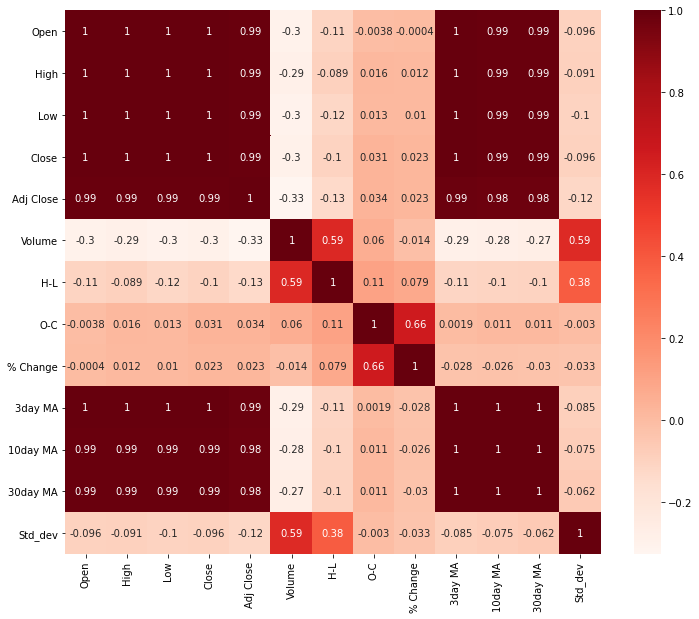

In [25]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [26]:
#Correlation with output variable
cor_target = abs(cor["Close"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Open         0.999390
High         0.999717
Low          0.999714
Close        1.000000
Adj Close    0.990972
3day MA      0.996396
10day MA     0.993349
30day MA     0.989873
Name: Close, dtype: float64